<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Hyper Zoo

### Deliverable:
For this lab, you will submit an ipython notebook via learningsuite. Your notebook will contain two parts, as described below.

### Grading standards:
Your notebook will be graded on the following:

* 35% Part 1: Clearly displayed 10 bars (one for baseline, one for each tweak 
independently)
* 5% Part 1: Small writeup of conclusions from independent tweaks
* 25% Part 2: Clear explanation of your tweaking strategy
* 25% Part 2: Actually run your tweaking strategy and show the results
* 10% Tidy and legible figures, including labeled axes where appropriate
* 10% Extra credit - Error bars on your figure in Part 1.

### Description:
The goal of this lab is to learn how to explore the combinatorial space of possible hyperparameter settings.

Many deep learning papers present some sort of tweak on standard deep learning, and empirically illustrate that it improves performance (ideally across a wide variety of architectures and datasets). It quickly becomes hard to know: which, if any, of these tweaks are truly important - and how do they work when combined?

For this lab, you will explore various tweaks to the basic classifier you coded in lab 1. There are two parts to the lab.

### Part 1
You must clearly show the individual effect of each tweak compared to the baseline. For this part, you should present a simple bar chart (or possibly two or more, depending on your layout), clearly labeled with the baseline performance, and then the performance of each tweak relative to baseline. You may plot absolute or relative performances; whichever is clearer.

You must include a few sentences describing what you can conclude from evaluating all of these tweaks.

Note: I am not requiring error bars for this lab, because they are computationally intensive. I have made them extra credit – although if we were doing this for real, they would be absolutely required!

### Part 2
You must think about how to find the best combination of tweaks. There is no right answer to this part; I want you to think carefully about how to search the space of possible combinations, and come up with a reasonable method for settling on a final combination of tweaks. I have tried to provide enough tweaks that it should be impossible to brute-force try all possible combinations (although that is certainly a valid strategy!).

For this part, you must include in your notebook a simple writeup describing your strategy (just a paragraph or two), and then show the final performance of whatever combination you hit upon.

Note that you will not be graded on absolute performance of any run; what is important is thinking clearly through which tweaks make a difference.

### The Tweaks
Your baseline classifier must be a “vanilla” classifier, with none of the features listed below. We will systematically add them in.

You must test the following:

* Activation functions: relu (baseline), leakyrelu, selu, elu, hardshrink
* Batchnorm: off (baseline), on (use one batchnorm per residual block)
* Label smoothing: off (baseline), on
* Learning rate: constant (baseline), CLR
* Regularization: off (baseline), dropout
* Initialization: xavier/he (baseline), orthogonal

So, for part one, your bar chart should have 10 different bars.

Some of these tweaks require additional parameters. You should either leave them at their default values, or think of some reasonable way to set them.

Note: pytorch does not (AFAIK) natively implement label smoothing. In the interests of focusing on hyperparameter searching, you may verbatim copy any internet code you like to help implement label smoothing.

### Hints
Activation functions and dropout can all be found in torch.nn

Initialization functions can be found in torch.nn.init

This lab should be pretty straightforward, with the right script – you should be able to iterate over tweaks and run your classifier in a tidy loop. Ideally, you'll code it up, let it run, and come back in a few hours to find the results!

If you find yourself cutting-and-pasting, you might want to rethink your strategy.

## Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
from PIL import Image, ImageOps
import gc
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

## Model Implementation - 20 Layer Resnet

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, batch_norm=True, activation=nn.ReLU, init_orthogonal=False, dropout=False):
    super(ResidualBlock, self).__init__()

    self.batch_norm = batch_norm
    self.dropout = dropout
    self.activation_function = activation
    self.activation = activation()

    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
    torch.nn.init.orthogonal_(self.conv1.weight)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.drop = nn.Dropout(p=0.2)
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    if init_orthogonal:
      nn.init.orthogonal_(self.conv1.weight)
      nn.init.orthogonal_(self.conv2.weight)

    if in_channels != out_channels:
      self.needs_shortcut = True
      self.conv_short = nn.Conv2d(in_channels, out_channels, 1, bias=False)
      self.bn_short = nn.BatchNorm2d(out_channels)

      if init_orthogonal:
        nn.init.orthogonal_(self.conv_short.weight)

      if batch_norm:
        self.shortcut = nn.Sequential(
          self.conv_short,
          self.bn_short
        )
      else:
        self.shortcut = self.conv_short

    else:
      self.needs_shortcut = False

  def forward(self, x):
    identity = x if not self.needs_shortcut else self.shortcut(x)
    out = self.conv1(x)

    if self.batch_norm:
      out = self.bn1(out)

    out = self.activation(out)

    if self.dropout:
      out = self.drop(out)

    out = self.conv2(out)

    if self.batch_norm:
      out = self.bn2(out)

    out += identity
    final_activation = self.activation_function()

    return final_activation(out)


In [0]:
class Resnet(nn.Module):
  def __init__(self, dataset, num_classes, batch_norm=False, activation=nn.ReLU, init_orthogonal=False, dropout=False):
    super(Resnet, self).__init__()

    x, y = dataset[0]
    in_channels, height, width = x.size()
    cstart = 64

    layers = []
    layers.append(ResidualBlock(in_channels, cstart, batch_norm=batch_norm, activation=activation, init_orthogonal=init_orthogonal, dropout=dropout))
    for i in range(19):
      layers.append(ResidualBlock(cstart, cstart, batch_norm=batch_norm, activation=activation, init_orthogonal=init_orthogonal, dropout=dropout))
  
    self.net = nn.Sequential(*layers)
    self.fc1 = nn.Linear(cstart * height * width, num_classes)

  def forward(self, x):
    # Residual Blocks
    out = self.net(x)

    # Flatten and narrow down to the number of classes
    out = torch.flatten(out, 1)
    out = self.fc1(out)

    return out

## Training Loop

In [0]:
class LabelSmoothLoss(nn.Module):
    def __init__(self, smoothing=0.0):
        super(LabelSmoothLoss, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [0]:
def train(activation=nn.ReLU, batch_norm=False, label_smoothing=False, clr=False, dropout=False, init_orthogonal=False, adam=False, lrbase=1e-4, lrmax=1e-2):
  NUM_EPOCHS = 5
  BATCH_SIZE = 300

  train_dataset = torchvision.datasets.CIFAR10('/content/cifar-train', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
  val_dataset = torchvision.datasets.CIFAR10('/content/cifar-val', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

  model = Resnet(train_dataset, 10, batch_norm=batch_norm, activation=activation, init_orthogonal=init_orthogonal, dropout=dropout) #PytorchResnet(dataset.num_classes())
  model = model.cuda()

  if label_smoothing:
    objective = LabelSmoothLoss(smoothing=0.00)
  else:
    objective = LabelSmoothLoss(smoothing=0.05)

  if adam:
    optimizer = optim.Adam(model.parameters(), lr=lrbase)
  else:
    optimizer = optim.SGD(model.parameters(), lr=lrbase)

  if clr:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lrbase, max_lr=lrmax)

  train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            shuffle=True)
  val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)
  
  accuracy = 0
  
  predictions = np.array([])
  actual = np.array([])
  
  for epoch in range(NUM_EPOCHS):
    loop = tqdm(total=len(train_loader), position=0, leave=True)

    for batch, (x, y_truth) in enumerate(train_loader):
      gc.collect()
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()
      y_hat = model(x)

      loss = objective(y_hat, y_truth.long())

      loss.backward()

      loop.set_description('Train - epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
      loop.update(1)

      optimizer.step()
      if clr:
        scheduler.step()

    if epoch == (NUM_EPOCHS - 1):
      with torch.no_grad():

        val_single_acc = []

        model.eval()

        for _, (val_x, val_y_truth) in enumerate(val_loader):
          gc.collect()
          val_x, val_y_truth = val_x.cuda(), val_y_truth.cuda()

          val_y_hat = model(val_x)
          val_acc = torch.eq(val_y_hat.argmax(1), val_y_truth.long()).float().mean()

          val_single_acc.append(val_acc.item())

        accuracy = np.mean(val_single_acc)
        print('\nValidation - epoch:{}, acc:{:.4f}'.format(epoch, accuracy))

    loop.close()

  return accuracy

## Part I Loop

In [0]:
# Obtain accuracies for all tweaks:
# Accuracies are the results given on the validation set after 5 epochs
try:
  baseline = train(activation=nn.ReLU, batch_norm=False, label_smoothing=False, clr=False, dropout=False, init_orthogonal=False)
  print('Finished baseline')
  leakyrelu = train(activation=nn.LeakyReLU, batch_norm=False, label_smoothing=False, clr=False, dropout=False, init_orthogonal=False)
  print('Finished leakyrelu')
  selu = train(activation=nn.SELU, batch_norm=False, label_smoothing=False, clr=False, dropout=False, init_orthogonal=False)
  print('Finished selu')
  elu = train(activation=nn.ELU, batch_norm=False, label_smoothing=False, clr=False, dropout=False, init_orthogonal=False)
  print('Finished elu')
  hardshrink = train(activation=nn.Hardshrink, batch_norm=False, label_smoothing=False, clr=False, dropout=False, init_orthogonal=False)
  print('Finished hardshrink')
  batchnorm = train(activation=nn.ReLU, batch_norm=True, label_smoothing=False, clr=False, dropout=False, init_orthogonal=False)
  print('Finished batchnorm')
  labelsmoothing = train(activation=nn.ReLU, batch_norm=False, label_smoothing=True, clr=False, dropout=False, init_orthogonal=False)
  print('Finished labelsmoothing')
  clr = train(activation=nn.ReLU, batch_norm=False, label_smoothing=False, clr=True, dropout=False, init_orthogonal=False)
  print('Finished clr')
  dropout = train(activation=nn.ReLU, batch_norm=False, label_smoothing=False, clr=False, dropout=True, init_orthogonal=False)
  print('Finished dropout')
  orthogonal = train(activation=nn.ReLU, batch_norm=False, label_smoothing=False, clr=False, dropout=False, init_orthogonal=True)
  print('Finished orthogonal')
except:
  __ITB__()

Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.9524: 100%|██████████| 167/167 [03:48<00:00,  1.23s/it]


Validation - epoch:4, acc:0.3319
Finished baseline


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.9672: 100%|██████████| 167/167 [03:48<00:00,  1.23s/it]


Validation - epoch:4, acc:0.3483
Finished leakyrelu


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.5345: 100%|██████████| 167/167 [03:50<00:00,  1.24s/it]


Validation - epoch:4, acc:0.4788
Finished selu


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.8165: 100%|██████████| 167/167 [03:49<00:00,  1.23s/it]


Validation - epoch:4, acc:0.4100
Finished elu


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:2.0987: 100%|██████████| 167/167 [03:43<00:00,  1.21s/it]


Validation - epoch:4, acc:0.2719
Finished hardshrink


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:2.4060: 100%|██████████| 167/167 [04:07<00:00,  1.34s/it]


Validation - epoch:4, acc:0.4003
Finished batchnorm


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.9065: 100%|██████████| 167/167 [03:48<00:00,  1.23s/it]


Validation - epoch:4, acc:0.3269
Finished labelsmoothing


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.1589: 100%|██████████| 167/167 [03:50<00:00,  1.24s/it]


Validation - epoch:4, acc:0.6324
Finished clr


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:2.0896: 100%|██████████| 167/167 [03:52<00:00,  1.26s/it]


Validation - epoch:4, acc:0.3141
Finished dropout


Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.7577: 100%|██████████| 167/167 [04:06<00:00,  1.35s/it]


Validation - epoch:4, acc:0.4150
Finished orthogonal


In [0]:
# Accuracies
baseline = .3319
leakyrelu = .3483
selu = .4788
elu = .4100
hardshrink = .2719
batchnorm = .4003
labelsmoothing = .3269
clr = .6324
dropout = .3141
orthogonal = .4150

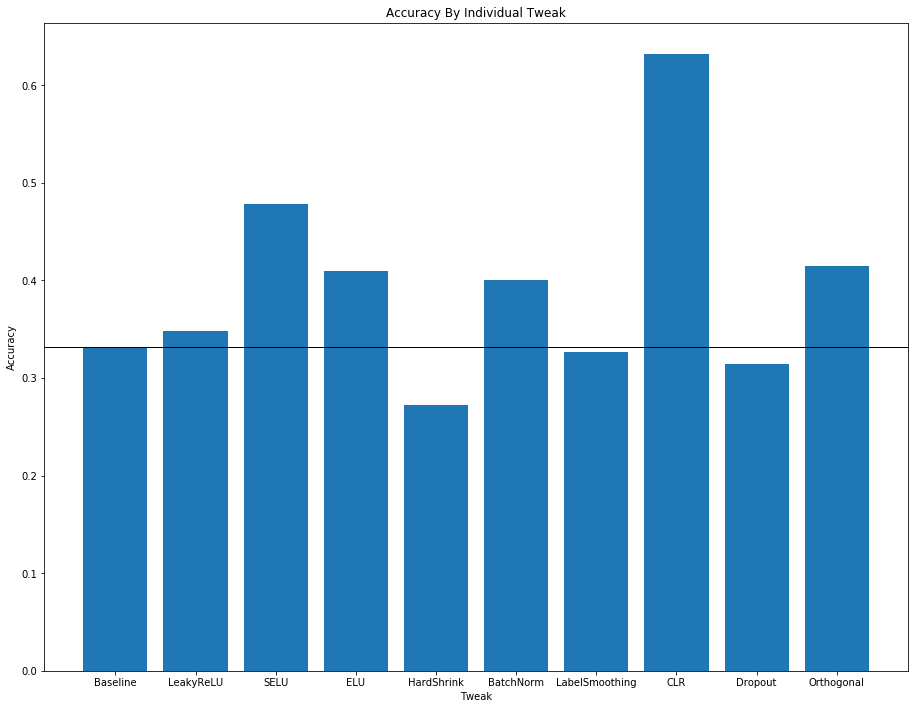

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 9))
ax = fig.add_axes([0,0,1,1])
labels = ['Baseline', 'LeakyReLU', 'SELU', 'ELU', 'HardShrink', 'BatchNorm', 'LabelSmoothing', 'CLR', 'Dropout', 'Orthogonal']
accuracies = [baseline, leakyrelu, selu, elu, hardshrink, batchnorm, labelsmoothing, clr, dropout, orthogonal]
ax.bar(labels, accuracies)
plt.axhline(y=baseline,linewidth=1, color='k')
plt.title("Accuracy By Individual Tweak")
plt.xlabel('Tweak')
plt.ylabel('Accuracy')
plt.show()

### Part I Conclusion

Looking at the individual tweaks, SELU outperformed all other activation functions. I was surprised that Orthogonal initialization had such a positive effect individually as well. CLR performed remarkably well compared to the other tweaks given. I assume this is because SGD was used over Adam. Adam may give more comparable results.

Overall, I was surprised that ReLU was second to worst on the activation functions we tried. This leads me to conclude that I should look at the activation function more in the future. Batch_Norm seems to always help. Dropout seems to only help if the network obtains high accuracy on the training data and is overfitting. I also want to look more in the future at initialization strategies, as orthogonal performed better than I anticipated.

## Part II

### Combination 1

Idea:
* Take all of the tweaks that performed above the baseline (using SELU, the best performing activation function)

Results:
* Loss was crazy at first, and still had a hard time settling down to some extent. I assume that it has something to do with the combination of SELU and CLR. It also could have something to do with the self-normalizing concept of SELU and an incorrect initialization strategy in conjunction with using batch_norm.
* The SNN paper described a Gaussian initialization strategy and a special kind of dropout due to its self-normalizing behavior. Let's remove SELU since we aren't following the given procedure.
* Overall, the network performed quite well comparitively on the validation set.

In [0]:
try:
  cbn1 = train(activation=nn.SELU, batch_norm=True, label_smoothing=False, clr=True, dropout=False, init_orthogonal=True)
except:
  __ITB__()

Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.0306: 100%|██████████| 167/167 [04:27<00:00,  1.45s/it]


Validation - epoch:4, acc:0.5197


### Combination 2

Idea:
* Change from SELU to the next best performing activation function due to the assumption that SELU and CLR was causing problems.

Results:
* Whether it was batch_norm or CLR, something was messing with SELU to get worse results.
* This shows that switching the activation function to ELU helped, likely due to the self-normalizing behavior of SELU.

In [0]:
try:
  cbn2 = train(activation=nn.ELU, batch_norm=True, label_smoothing=False, clr=True, dropout=False, init_orthogonal=True)
except:
  __ITB__()

Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:0.9062: 100%|██████████| 167/167 [04:27<00:00,  1.45s/it]


Validation - epoch:4, acc:0.6139


### Combination 3

Idea:
* I noticed that the loss for the previous two combinations was lower than the original CLR run. However, the accuracy wasn't nearly as good. Maybe the network is overfitting on the training set just slighly. Let's add in dropout.

Results:
* It seems that adding dropout helped increase the accuracy by 4 percentage points.


In [0]:
try:
  cbn3 = train(activation=nn.ELU, batch_norm=True, label_smoothing=False, clr=True, dropout=True, init_orthogonal=True)
except:
  __ITB__()

Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.0754: 100%|██████████| 167/167 [04:31<00:00,  1.47s/it]


Validation - epoch:4, acc:0.6538


### Combination 4
Idea:
* Thus far, we have been using SGD as the optimizer (to allow CLR to work natively in pytorch). Let's keep all the tweaks that helped improve accuracy, but remove CLR in favor of a standalone Adam optimizer.

Results:
* The higher base learning rate and max learning rate resulted in massive losses at the beginning until we got the gradients settled down.
* Although it improved, the losses were still jumping all over the place. Adjusting the learning rate is likely a huge factor in determing the success of your model (We only have a finite amount of time to train).

In [0]:
try:
  cbn4 = train(activation=nn.ELU, batch_norm=True, label_smoothing=False, clr=False, dropout=True, init_orthogonal=True, adam=True)
except:
  __ITB__()

Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.1345: 100%|██████████| 167/167 [04:34<00:00,  1.51s/it]


Validation - epoch:4, acc:0.6146


### Combination 5
Idea:
* Increase the learning rate for Adam and use a different initialization. Maybe we simply need more time to converge or a quicker learning rate.

Results:


In [0]:
try:
  cbn5 = train(activation=nn.ELU, batch_norm=True, label_smoothing=False, clr=False, dropout=True, init_orthogonal=False, adam=True, lrbase=1e-3, lrmax=5e-2)
except:
  __ITB__()

Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.1360: 100%|██████████| 167/167 [04:34<00:00,  1.50s/it]


Validation - epoch:4, acc:0.6608


### Combination 6

Idea:
* Maybe the learning rate using SGD was a little too low and it simply couldn't converge quick enough. What if we increase the bounds of the learning rate slightly to see if we converge quicker, while still using CLR.

Results:
* 

In [0]:
try:
  cbn6 = train(activation=nn.ELU, batch_norm=True, label_smoothing=False, clr=True, dropout=True, init_orthogonal=True, adam=False, lrbase=1e-3, lrmax=5e-2)
except:
  __ITB__()

Files already downloaded and verified
Files already downloaded and verified


Train - epoch:4, loss:1.3752: 100%|██████████| 167/167 [04:31<00:00,  1.47s/it]


Validation - epoch:4, acc:0.5264


## Conclusion

When searching for the best hyper-parameters, I think a great place to start is by choosing your activation function. The activation may determine the impact on the rest of the hyper parameters that you choose to select. For example, SELU performs best when weights are initialized with Gaussian and a special kind of dropout is used (to preserve self-normalization). Thus, the hyper-parameters of batch norm, initialization, and regularization will be greatly dependent on your choice of activation function.

Cyclic learning rates improve performance. However, they tend not to work all that well with adaptive optimizers. It seems that CLR should be used whenever you use SGD or anything non-adaptive. There is a trade-off here, because usually an optimizer like Adam will converge much quicker than SGD. This may require some tuning to discover which works better. Along these lines, the chosen learning rates are extremely important as well.

Overall, my best set of hyper-parameters included ELU, Batch_Norm, Label_Smoothing, Adam Optimizer, Dropout, and Xavier initialization.
Compared to the baseline performance, the best hyper-parameter combination jumped over 30 percentage points. There was also nearly a 50 percentage point difference between the best hyper-parameter combination and the worst hyper-parameter combination. Are hyper-parameters important? I think so!